### Poom's ConvNet for One-Shot Learning on the Omniglob Dataset

I follow the approach from [1], which reported a whopping 93.8% accuracy on 20-way one-shot character matching with some slight modifications: 

* weight decay replaces batch normalization.
* rather than downsizing the image, a thin plate spline spatial transformer network is used to crop input images [2]
* the elementwise complex norm of the fourier transform of the image is fed through a parallel network of the same architecture whose prediction is combined with the original one using learned weights to obtain the final prediction.
* kernels of the first convolutional layer is larger to account for the intuition that larger image means larger features
* Munkres assignment algorithm is used to find the maximum probability matching [3]
* elastic distortions, small random rotations and small random shearing is used to augment the dataset

These weird tricks and some more minor ones allow me to achieve a __prediction acccuracy of 97.8%__ which is almost a third of [1] __using a training set that's 3/4th of the size__. The intuition behind adding the fourier transform is that the elementwise norm of the fourier transform is translation invariant, which is useful when we want features that are independent of the position of the character in the image. (However, rotations commute with fourier transform, so we still need the spatial transformer network.)

Disclaimer: the thin-plate spline spatial transfomer network (`crop.py`) is `iwyoo`'s implementation [4].

[1] https://arxiv.org/abs/1606.04080  
[2] https://arxiv.org/abs/1506.02025  
[3] https://en.wikipedia.org/wiki/Hungarian_algorithm  
[4] https://github.com/iwyoo/TPS_STN-tensorflow

In [1]:
import functools
import threading

import crop
import util
import time

import tensorflow as tf
import scipy.optimize as opti
import numpy.random as rd
import numpy as np

import matplotlib.pyplot as plt

/Users/eight1911/learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import random

In [3]:
def threadify(func):
    "function runs in a new thread."

    @functools.wraps(func)
    def run(*args, **kwds):
        new_thread = threading.Thread(
            target = func,
            args   = args,
            kwargs = kwds)
        new_thread.start()
        return new_thread

    return run

In [4]:
def pairwise_cosine(a, b):
    """
    computes the pairwise cosine distance of two batches of vectors
    
    input
    =====
    a : a tensor of shape [num_batch, num_features]
      - a matrix of features
    b : a tensor of shape [num_batch, num_features]
      - a matrix of features
    
    output
    ======
    m : a square matrix m such that m[i, j] is the
        cosine distance between a[i] and b[j]
    """
    a = tf.transpose(a) / tf.norm(a, axis=1)
    b = tf.transpose(b) / tf.norm(b, axis=1)
    return tf.transpose(a) @ b

In [5]:
def transform(x, pdrop, cropsize):
    """
    the spatial transformer layer of the network, inputs an image
    and returns a thin plate spline distorted version of a subimage
    of the image that the network thinks will maximize presence of 
    features
    
    input
    =====
    
    x : tensor of shape [num_batch, img_width, img_height]
      - the image tensor that is raw input of transform network
    pdrop : a float tensor or a float
      - the dropout probability
    cropsize : a tuple (int, int)
      - the size of the output image. 
    
    output
    ======
    img : tensor of shape [num_batch, cropsize[0], cropsize[1], 1]
        - the output image
    """
    
    # theta is the control points of the thin-plate spline.
    theta = tf.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1])
    theta = tf.layers.conv2d(theta, 16, [5, 5], [2, 2], 'same')
    theta = tf.layers.max_pooling2d(theta, [2, 2], [2, 2], 'same')
    theta = tf.nn.leaky_relu(theta, 0.03)

    theta = tf.layers.conv2d(theta, 16, [5, 5], [2, 2], 'same')
    theta = tf.layers.max_pooling2d(theta, [2, 2], [2, 2], 'same')
    theta = tf.nn.leaky_relu(theta, 0.03)

    theta = tf.layers.conv2d(theta, 16, [5, 5], [1, 1], 'same')
    theta = tf.nn.leaky_relu(theta, 0.03)

    u = theta.shape[1] * theta.shape[2] * theta.shape[3]

    theta = tf.reshape(theta, [-1, u])
    theta = tf.layers.dropout(theta, pdrop)
    theta = tf.layers.dense(theta, 40)
    theta = tf.nn.leaky_relu(theta, 0.03)
    theta = tf.layers.dropout(theta, pdrop)
    theta = tf.layers.dense(theta, 18)

    theta = tf.reshape(theta, [-1, 9, 2])
    
    # Initialze with a preference for zoomed in crops
    # this is to force the spatial transformer network
    # to "do or die." Either it learns good crops or the 
    # network performace is compromised.
    _x = np.linspace(0.3, -0.3, 3)
    _y = np.linspace(0.3, -0.3, 3)
    _x, _y = np.meshgrid(_x, _y)
    _x = _x.reshape([-1])
    _y = _y.reshape([-1])

    theta += np.vstack([_x, _y]).T
    
    return theta, crop.TPS_STN(x, 3, 3, theta, (32, 32))

In [6]:
def fft_norm(image):
    """
    the norm of the fourier transform of the image
    
    input
    =====
    x : tensor of shape [num_batch, img_width, img_height]
      - the input image
    output
    ======
    u : tensor of shape [num_batch, img_width, img_height / 2]
      - the fourier transform of the input image
    """
    image = tf.reshape(image, [image.shape[0], image.shape[1], image.shape[2]])
    image = tf.spectral.rfft2d(image)
    image = tf.reshape(image, [-1, image.shape[1], image.shape[2], 1])
    return tf.sqrt(tf.real(image)**2 + tf.imag(image)**2)

In [7]:
def push(x, pdrop):
    """
    the main convolutional layers. we apply this to the image and its 
    fourier transform in parallel.
    
    input
    =====
    x : tensor of shape [num_batch, img_width, img_height]
      - the input image
    pdrop : a float tensor or a float
      - the dropout probability
    
    output
    ======
    y : tensor of shape [num_batch, 64]
      - the output image (will raise an error if the input image is too big)
    """
    x = tf.layers.conv2d(x, 64, [5, 5], [2, 2], 'same')
    x = tf.layers.max_pooling2d(x, [2, 2], [2, 2], 'same')
    x = tf.nn.leaky_relu(x, 0.03)

    x = tf.layers.conv2d(x, 64, [3, 3], [1, 1], 'same')
    x = tf.layers.max_pooling2d(x, [2, 2], [2, 2], 'same')
    x = tf.nn.leaky_relu(x, 0.03)

    x = tf.layers.conv2d(x, 64, [3, 3], [1, 1], 'same')
    x = tf.layers.max_pooling2d(x, [2, 2], [2, 2], 'same')
    x = tf.nn.leaky_relu(x, 0.03)

    x = tf.layers.conv2d(x, 64, [3, 3], [1, 1], 'same')
    x = tf.layers.average_pooling2d(x, [2, 2], [2, 2], 'same')

    return tf.reshape(x, [x.shape[0], 64])

At this point you might notice that save for the spatial transformer layer, each layer in our network $\mathcal{N}$ has the property that for any scalar $c \in \mathbb{R}$
   $$ \mathcal{N}(c\cdot\text{image}) = c\mathcal{N}(\text{image}). $$

which is quite a nice property because I expect that the saturation and the brightness of the image should not affect the output of the network. However, since the norm of the output is independent of its direction, and since I am using the cosine distance which is independent of the norm, the magnitude of the weights in collective do not affect the prediction of the network. Because of this, using weight decay may cause the weights to go so low that the predictions become unstable. To solve this problem, I also added another regularization condition that the norm of the output is approximately 1.

Below I define a class that puts everything together (including a function for training the network and one for predicting inputs.) In particular, you may notice that I choose to add the confusion matrix of the prediction of the fourier transform convnet and the regular image convnet rather than concatenate their output vectors and compute the confusion matrix from one final vector. This is (a.) to make it possible so that I can learn their relative contribution (using `self.balancer`) and (b.) to get two relatively independent predictions rather than one.

In [21]:
class MatchingNetwork:

    def __init__(self, k):
        self.k = k
        self.inpsize = (105, 105)
        self.cropsize = (32, 32)

        self.pdrop = tf.placeholder(tf.float32)
        self.rate = tf.placeholder(tf.float32)
        self.inp = tf.placeholder(tf.float32, [2*k, *self.inpsize])

        self.x = tf.reshape(self.inp, [*self.inp.shape, 1])
        self.theta, self.t = transform(self.x, self.pdrop, self.cropsize)
        self.t = tf.reshape(self.t, [2*k, *self.cropsize, 1])
        self.u = tf.minimum(fft_norm(self.t) / 10, 10)

        self.y = push(self.t, self.pdrop)
        self.z = push(self.u, self.pdrop)

        # start with high confidence
        self.balancer = (wy, wz, wmax, wmin) = [
            tf.Variable(2.0, dtype=tf.float32),
            tf.Variable(2.0, dtype=tf.float32),
            tf.Variable(2.0, dtype=tf.float32),
            tf.Variable(2.0, dtype=tf.float32),
        ]

        self.yconfusion = pairwise_cosine(self.y[:k], self.y[k:])
        self.zconfusion = pairwise_cosine(self.z[:k], self.z[k:])
        self.confusion = (wy * self.yconfusion 
                        + wz * self.zconfusion
                        + wmax * tf.maximum(self.yconfusion, self.zconfusion)
                        + wmin * tf.minimum(self.yconfusion, self.zconfusion))
        self.optimizer = tf.train.AdamOptimizer(self.rate / tf.norm(self.balancer))

        # penalize vectors that are too large or too small
        self.normloss = (tf.reduce_mean((tf.norm(self.y, axis=1) - 1) ** 2)
                       + tf.reduce_mean((tf.norm(self.z, axis=1) - 1) ** 2)
                       + tf.reduce_mean((tf.norm(self.s, axis=1) - 1) ** 2))
        # self.l2loss = tf.reduce_sum([tf.reduce_mean(i**2) for i in tf.trainable_variables()])
        self.loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self.confusion, labels=np.arange(20))
        self.train_ops = self.optimizer.minimize(
            tf.reduce_sum(self.loss) + self.normloss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())


    def predict(self, aset, bset):
        confusion = self.sess.run(self.confusion, feed_dict={
            self.inp   : np.vstack([aset, bset]),
            self.pdrop : 0.0
        })
        
        exp = np.exp(confusion)
        prob = (exp.T / exp.sum(axis=1)).T
        logprob = np.log(prob)

        # minimize confusion by finding the optimal 
        # (maximum probability) matching in the complete 
        # bipartite graph
        return opti.linear_sum_assignment(-logprob)

    def train(self, aset, bset, rate=1e-4):
        # assume that for all i, aset[i] is the 
        # same character as bset[i]
        
        # to make sure that this doesn't introduce
        # some bugs, we will permute the inputs when
        # we test
        p = [self.loss, self.train_ops]
        l, _ = self.sess.run(p, feed_dict={
            self.inp   : np.vstack([aset, bset]),
            self.rate  : rate,
            self.pdrop : 0.5
        })

        return l.mean()

    def accuracy(self, stream):
        apermutator = np.arange(self.k)
        bpermutator = np.arange(self.k)
        n_correct = 0
        for aset, bset in stream:
            rd.shuffle(apermutator)
            rd.shuffle(bpermutator)
            ashuffled = aset[apermutator]
            bshuffled = bset[bpermutator]

            apred, bpred = self.predict(ashuffled, bshuffled)
            # prediction is that
            # 
            #     aset[apermutator][apred] ~= bset[bpermutator][bpred]
            # 
            # but we have that aset ~= bset, therefore, we must
            # have that, if our prediction is correct, then
            # 
            #     apermutator[apred] == bpermutator[bpred]
            # 
            nc = np.sum(apermutator[apred] == bpermutator[bpred])
            n_correct += nc
        return n_correct

Ok, the nitty gritty part starts here

In [22]:
random.seed(0)
tf.set_random_seed(0)
rd.seed(0)

m = MatchingNetwork(20) # twenty-way matching

Below is shown the output of the untrained spatial transformer network (STN) (left) against the input image (right). Notice how the images are zoomed in. This is to force the STN to either learn weights or compromise the performance of the network.

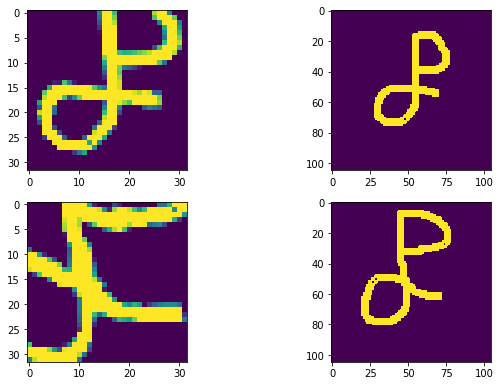

In [23]:
aset, bset = util.sample(20, "testing")
test = m.sess.run(m.t, feed_dict={
    m.inp : np.vstack([aset, bset]),
    m.pdrop : 0.5
})
test = test.reshape([-1, 32, 32])

fig = plt.figure(figsize=(10, 10))
a = fig.add_subplot(3,2,1)
plt.imshow(test[0])
a = fig.add_subplot(3,2,2)
plt.imshow(aset[0])

a = fig.add_subplot(3,2,3)
plt.imshow(test[20])
a = fig.add_subplot(3,2,4)
plt.imshow(bset[0])

plt.show()

I define the function for training below. I partition our data set into three parts. The first one is the training data comprising of 964 characters. The next 100 characters form my validation set (which admittedly is a part of the evaluation set, so I am cheating at little here.) and finally the last 559 characters is my test set. Each character has twenty sample images.

One function you will see below is util.sample which has the following signature

    util.sample(k : int, mode : string, outsize : int) -> (numpy array, numpy array)
   
The function is defined in `util.py` and essentially runs samples two images each from `k` different characters, and apply some random augmentations (if `mode == "training"`) and return two arrays `(aset, bset)` such that for each `i`, `aset[i]` is the same character as `bset[i]`, but written by two different people. This sampling distribution (save the data augmentation) is follows the implementation in [1].


In [24]:
n = 300
hist_acc = []
rate_exp = -np.arange(12000) / 15000
rate_range = np.exp(rate_exp) * 5e-4
num_correct = 10
for i, rate in enumerate(rate_range):
    if i % 6 == 0:
        nc = m.accuracy([util.sample(20, "validating")])
        hist_acc.append(nc)
        last_acc = hist_acc[-1]
        running_acc = np.mean(hist_acc[-n:])/20
        print(f"\r{len(hist_acc)} : {last_acc} : {running_acc}", end="")
    aset, bset = util.sample(20, "training")
    m.train(aset, bset, rate)

195 : 20 : 0.7633333333333334

ValueError: matrix contains invalid numeric entries

In [ ]:
n = 150
plt.plot([1 - np.mean(hist_acc[i:i+n]) / 20 for i in range(0, len(hist_acc)-n)])
plt.title("validation error")
plt.xlabel("number of iterations (x6)")
plt.ylabel(f"average prediction error over {n} trials")
# plt.yscale("log")
print(len(hist_acc), ":", np.mean(np.array(hist_acc[-n:]) * 50))

In [ ]:
# final_acc = m.accuracy(util.sample(20, "testing") for i in range(5000))
# print(final_acc)